In [7]:
import os
import geopandas as gpd

# os.environ["USE_PYGEOS"] = os.environ.get("USE_PYGEOS", "0")
local_crs = 32636
# path to data
example_data_path = "./data"

In [8]:
from masterplan_tools.method.blocks import CutParameters

city_geometry = gpd.read_parquet(os.path.join(example_data_path, "city_geometry.parquet")).to_crs(local_crs)
water_geometry = gpd.read_parquet(os.path.join(example_data_path, "water_geometry.parquet")).to_crs(local_crs)
roads_geometry = gpd.read_parquet(os.path.join(example_data_path, "roads_geometry.parquet")).to_crs(local_crs)
railways_geometry = gpd.read_parquet(os.path.join(example_data_path, "railways_geometry.parquet")).to_crs(local_crs)

#basically we need just these 4 geometries to cut some blocks
cut_params = CutParameters(
  city=city_geometry,
  water=water_geometry,
  roads=roads_geometry,
  railways=railways_geometry
)

In [9]:
from masterplan_tools.method.blocks import LandUseParameters

no_development = gpd.read_file(os.path.join(example_data_path, "no_development_pzz.geojson"), mask=city_geometry.to_crs(4326)).to_crs(local_crs)
no_development = no_development[no_development['RAYON']=='Василеостровский']
landuse = gpd.read_file(os.path.join(example_data_path, "landuse_zone_pzz.geojson"), mask=city_geometry.to_crs(4326)).to_crs(local_crs)

#but to improve our method we should use LU filtering
#if we don't set landuse parameters, no LU filtering will be applied to the blocks 
#(which can be ok if you need so)
lu_params = LandUseParameters(
  no_development=no_development,
  landuse=landuse
)

In [10]:
from masterplan_tools.method.blocks import ClusteringParameters

#buildings geometries are used to divide blocks by buildings clusters
buildings_geom = gpd.read_file(os.path.join(example_data_path, "buildings_blocks.geojson"), mask=city_geometry.to_crs(4326)).to_crs(local_crs)

#same is applied to clustering params
clustering_params = ClusteringParameters(buildings=buildings_geom)

In [16]:
from masterplan_tools.method import BlocksCutter

blocks = BlocksCutter(
  cut_parameters=cut_params, 
  lu_parameters=lu_params,
  clustering_parameters=clustering_params
).get_blocks()

/home/vasilstar/masterplanning/masterplan_tools/method/blocks/landuse_filter.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  landuse = ox.geometries_from_polygon(
/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1803: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union
100%|██████████| 1/1 [00:00<00:00,  8.90it/s]
1411it [00:01, 908.36it/s] 


In [17]:
blocks.to_gdf()

,geometry,id,landuse
0,"POLYGON ((344943.719 6647610.514, 344959.205 6...",0,buildings
1,"POLYGON ((344968.687 6647544.000, 344971.625 6...",1,buildings
2,"POLYGON ((344929.592 6647257.521, 344931.964 6...",2,buildings
3,"POLYGON ((344840.676 6647432.974, 344853.943 6...",3,buildings
4,"POLYGON ((344856.398 6647391.171, 344900.097 6...",4,buildings
...,...,...,...
1349,"POLYGON ((346243.206 6647701.284, 346243.206 6...",1406,selected_area
1350,"POLYGON ((347483.986 6647345.029, 347483.627 6...",1407,selected_area
1351,"POLYGON ((347463.977 6647381.345, 347456.841 6...",1408,selected_area
1352,"POLYGON ((344028.826 6648834.242, 344112.884 6...",1409,no_dev_area


<Axes: >

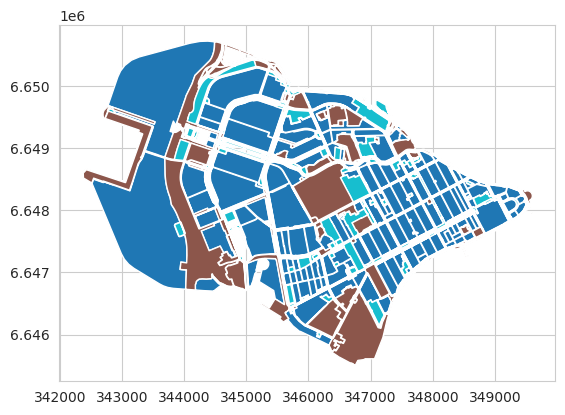

In [18]:
blocks.to_gdf().plot(column='landuse')